In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import old_functions as old_func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
dask.config.set({'array.slicing.split_large_chunks': False})
import matplotlib.gridspec as gridspec

In [3]:
# Precip data 
data = old_func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/pr/gr1.5/').pr.sel(time=slice('1900-01', '2014-12')).chunk('auto')
data = data.sortby('model')

In [4]:
# Select out the 20 models we are using (no pr for KIOST in lp01 or oi10)
keep = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-g3',
        'GFDL-CM4', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'KACE-1-0-G', 'MIROC6', 'MPI-ESM1-2-HR',
        'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM']

data = data.sel(model=keep)*86400 # convert to mm/day

In [5]:
# Calculate anomalies 
clims = data.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anoms = (data.groupby('time.month') - clims).chunk('auto')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 115 times more chunks
  return self.array[key]


In [6]:
# SST data
data = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_ts_quad_detrend_1900_2015.nc')
# Calculate Nino3.4 index
nino34_list = []
for m in data.model:
    nino34_list.append(func.nino34_index(data.sel(model=m), '1950-01', '1979-12'))
nino34 = xr.DataArray(nino34_list, dims=['model', 'time'], coords=[data.model, data.time])

In [7]:
nino34_19 = nino34.drop_sel(model='KIOST-ESM')

In [8]:
%%time
elnino_list_pr = []
lanina_list_pr = []
for m in nino34_19.model:
    el, la = func.sst_comp(nino34_19.sel(model=m), anoms.sel(model=m), 'DJF', 0.5, 6)
    elnino_list_pr.append(el)
    lanina_list_pr.append(la)
    
elnino_pr = xr.concat(elnino_list_pr, dim='model').chunk('auto')
lanina_pr = xr.concat(lanina_list_pr, dim='model').chunk('auto')

CPU times: user 17min 25s, sys: 5min 46s, total: 23min 12s
Wall time: 46min 4s


In [9]:
elnino_pr = elnino_pr.compute()
lanina_pr = lanina_pr.compute()

In [10]:
# Rx1day
regrid_paths = '/g/data/w40/rl5183/CMIP6_ETCCDI_rx1_regrid/*'
ds = xr.open_mfdataset(regrid_paths, combine='nested', concat_dim='model', chunks={'time':-1, 'lat':110, 'lon':110})
# models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-g3',
#         'GFDL-CM4', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC6', 'MPI-ESM1-2-HR',
#         'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM']
ds.coords['model'] = data.model
rx1 = ds.rx1dayETCCDI.sel(time=slice('1900-01', '2014-12'))

In [11]:
# anomalies
clims = rx1.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anoms = (rx1.groupby('time.month') - clims).chunk('auto')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 115 times more chunks
  return self.array[key]


In [12]:
%%time
elnino_list_rx1 = []
lanina_list_rx1 = []
for m in nino34.model:
    el, la = func.sst_comp(nino34.sel(model=m), anoms.sel(model=m), 'DJF', 0.5, 6)
    elnino_list_rx1.append(el)
    lanina_list_rx1.append(la)
    
elnino_rx1 = xr.concat(elnino_list_rx1, dim='model').chunk('auto')
lanina_rx1 = xr.concat(lanina_list_rx1, dim='model').chunk('auto')

CPU times: user 18min 14s, sys: 6min 14s, total: 24min 29s
Wall time: 50min 57s


In [13]:
elnino_rx1 = elnino_rx1.compute()
lanina_rx1 = lanina_rx1.compute()

In [14]:
elnino_rx1_19 = elnino_rx1.drop_sel(model='KIOST-ESM')

In [15]:
lanina_rx1_19 = lanina_rx1.drop_sel(model='KIOST-ESM')

In [16]:
# Save as net cdf?

In [17]:
from importlib import reload 
func=reload(func)

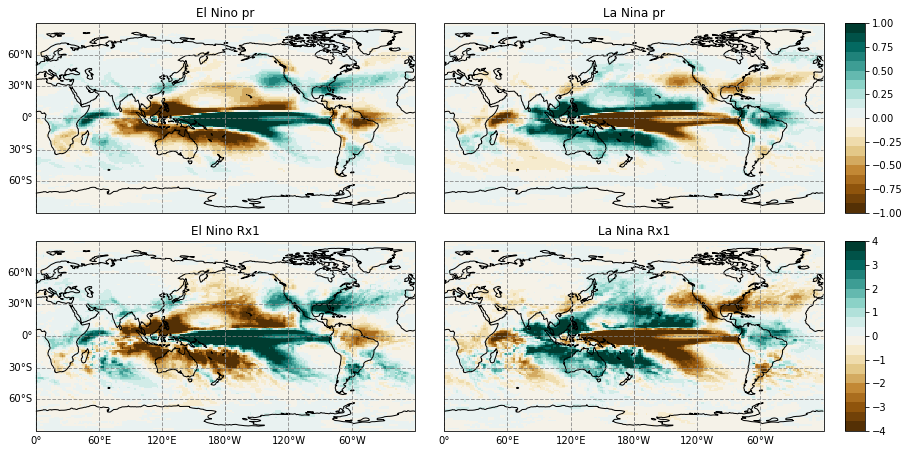

In [18]:
fig = plt.figure(figsize = (15, 7.5))
gs = gridspec.GridSpec(2,3, wspace=0.05, hspace=.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(180))
im = elnino_pr.mean(dim='model').plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('BrBG', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino pr')
ax = func.format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(180))
im = lanina_pr.mean(dim='model').plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.get_cmap('BrBG', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina pr')
ax = func.format_gridlines(ax)

# First colorbar 
cax = plt.subplot(gs[0, 2])
cbar = plt.colorbar(im, cax)

ax = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(180))
im = elnino_rx1.mean(dim='model').plot(ax=ax, vmin=-4, vmax=4, cmap=plt.cm.get_cmap('BrBG', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino Rx1')
ax = func.format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(180))
im = lanina_rx1.mean(dim='model').plot(ax=ax, vmin=-4, vmax=4, cmap=plt.cm.get_cmap('BrBG', 20), add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina Rx1')
ax = func.format_gridlines(ax, bottom_labels=True)

# Second colorbar 
cax2 = plt.subplot(gs[1, 2])
cbar = plt.colorbar(im, cax2) 

#plt.savefig('CMIP6_ENSO_comps_pr_rx1day', bbox_inches='tight', dpi=300)

In [19]:
# Sign Comp
elnino_sc_pr_rx1 = func.sign_corr(elnino_pr.mean(dim='model'), elnino_rx1.mean(dim='model'))
lanina_sc_pr_rx1 = func.sign_corr(lanina_pr.mean(dim='model'), lanina_rx1.mean(dim='model'))

elnino_sc_pr_rx1 = xr.DataArray(elnino_sc_pr_rx1, 
                                dims=elnino_pr.mean(dim='model').dims, 
                                coords=elnino_pr.mean(dim='model').coords)
lanina_sc_pr_rx1 = xr.DataArray(lanina_sc_pr_rx1, 
                                dims=elnino_pr.mean(dim='model').dims, 
                                coords=elnino_pr.mean(dim='model').coords)

# elnino_sc_pr_rx1.to_netcdf('elnino_sc_pr_rx1_mmm.nc')
# lanina_sc_pr_rx1.to_netcdf('lanina_sc_pr_rx1_mmm.nc')

In [20]:
# Sign comp individual models 
emptylist = []
for m in elnino_pr.model:
    emptylist.append(func.sign_corr(elnino_pr.sel(model=m), elnino_rx1_19.sel(model=m)))

elnino_pr_rx1_sign = xr.DataArray(emptylist, dims=elnino_pr.dims, coords=elnino_pr.coords)
#elnino_pr_rx1_sign.to_netcdf('elnino_pr_rx1_sign.nc')

In [21]:
emptylist = []
for m in lanina_pr.model:
    emptylist.append(func.sign_corr(lanina_pr.sel(model=m), lanina_rx1_19.sel(model=m)))

lanina_pr_rx1_sign = xr.DataArray(emptylist, dims=lanina_pr.dims, coords=lanina_pr.coords)
#elnino_pr_rx1_sign.to_netcdf('elnino_pr_rx1_sign.nc')

In [22]:
elnino_pr_rx1_same, elnino_pr_rx1_opp = func.sign_percents(elnino_pr_rx1_sign, 19)
lanina_pr_rx1_same, lanina_pr_rx1_opp = func.sign_percents(lanina_pr_rx1_sign, 19)

In [23]:
elnino_pr_rx1_same_mask = elnino_pr_rx1_same.where(elnino_pr_rx1_same >= 80)
elnino_pr_rx1_opp_mask = elnino_pr_rx1_opp.where(elnino_pr_rx1_opp >= 80)

lanina_pr_rx1_same_mask = lanina_pr_rx1_same.where(lanina_pr_rx1_same >= 80)
lanina_pr_rx1_opp_mask = lanina_pr_rx1_opp.where(lanina_pr_rx1_opp >= 80)

In [24]:
import matplotlib as mpl
color_array = ['#FFD1B3', '#accbff', '#4188ff', '#FE994A', 'lightgrey']
cmap = mpl.colors.ListedColormap(color_array)
bounds=np.arange(-1,5)
norm=mpl.colors.BoundaryNorm(bounds+0.5, cmap.N)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


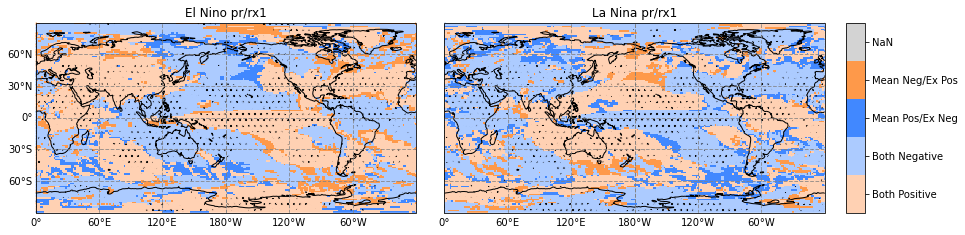

In [27]:
fig = plt.figure(figsize = (15, 3.5))
gs = gridspec.GridSpec(1,3, wspace=0.05, hspace=.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(180))
im = elnino_sc_pr_rx1.plot(ax=ax, cmap=cmap, norm=norm, levels=bounds+0.5, add_colorbar=False, transform=ccrs.PlateCarree())
elnino_pr_rx1_same_mask.plot.contourf(ax=ax, alpha=0, add_colorbar=False, hatches=[None, '..'], transform=ccrs.PlateCarree())
elnino_pr_rx1_opp_mask.plot.contourf(ax=ax, alpha=0, add_colorbar=False, hatches=[None, '..'], transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Nino pr/rx1')
ax = func.format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(180))
im = lanina_sc_pr_rx1.plot(ax=ax, cmap=cmap, norm=norm, levels=bounds+0.5, add_colorbar=False, transform=ccrs.PlateCarree())
lanina_pr_rx1_same_mask.plot.contourf(ax=ax, alpha=0, add_colorbar=False, hatches=[None, '..'], transform=ccrs.PlateCarree())
lanina_pr_rx1_opp_mask.plot.contourf(ax=ax, alpha=0, add_colorbar=False, hatches=[None, '..'], transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Nina pr/rx1')
ax = func.format_gridlines(ax, bottom_labels=True)

# Colorbar 
cax = plt.subplot(gs[0, 2])
cbar = plt.colorbar(im, cax, ticks=bounds) 
cbar.ax.set_yticklabels(['empty', 'Both Positive', 'Both Negative', 'Mean Pos/Ex Neg', 'Mean Neg/Ex Pos', 'NaN',]);

#plt.savefig('CMIP6_ENSO_comps_pr_rx1day_sign_comp', bbox_inches='tight', dpi=300)